In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix


In [28]:
# Read the preprocessed data

# Construct the full path to the CSV file
csv_file_path_pre_processed = Path.cwd().parent / 'preprocessed_data_2.csv'
csv_file_path_raw = Path.cwd().parent / 'training_data_vt2025.csv'

# Read the CSV file using pandas
pre_processed_data = pd.read_csv(csv_file_path_pre_processed)
raw_data = pd.read_csv(csv_file_path_raw)

In [29]:
# Split the data into input values, X, and output value, y
X = pre_processed_data.drop(columns=['increase_stock'])
y = pre_processed_data['increase_stock']

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Best Hyperparameters Found:
{'shrinkage': 'auto', 'solver': 'lsqr'}
Best F1 Score from Cross-Validation: 0.5814

 Best Threshold Found: 0.36
Best F1-Score at Best Threshold: 0.7188

 Final Model Evaluation:
Accuracy: 0.9375
Precision: 1.0000
Recall: 0.6552
F1-Score: 0.7917
ROC-AUC Score: 0.8276

 Classification report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       262
           1       1.00      0.66      0.79        58

    accuracy                           0.94       320
   macro avg       0.96      0.83      0.88       320
weighted avg       0.94      0.94      0.93       320



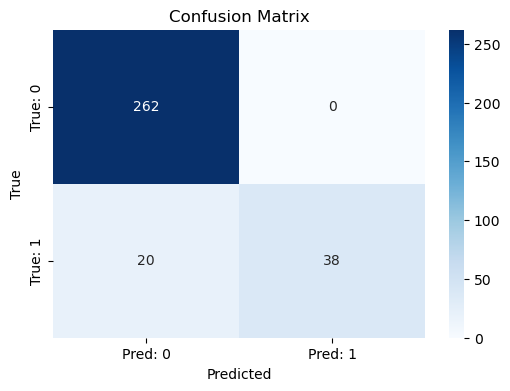

In [31]:
# Set aside test data that is kept unseen until final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define column indices for different scalers
standardize_cols = ['temp','dew', 'windspeed','day_of_week_sin', 'day_of_week_cos', 'hour_of_day_sin', 'hour_of_day_cos', 'month_sin', 'month_cos']
normalize_cols = ['humidity', 'cloudcover']   
robust_cols = ['precip', 'snowdepth', 'visibility']


# Define the column transformer with different scalers
preprocessor = ColumnTransformer([
    ('std_scaler', StandardScaler(), standardize_cols), 
    ('minmax_scaler', MinMaxScaler(), normalize_cols),   
    ('robust_scaler', RobustScaler(), robust_cols)
], remainder='passthrough')

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline: Scaling + LDA
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply different scalers
    ('lda', LinearDiscriminantAnalysis())
])

param_grid = [
    {'lda__solver': ['svd']},  # SVD does not take shrinkage
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', None]}  # Only these solvers use shrinkage
]

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters, but remove the 'lda__' prefix
best_params = {key.replace("lda__", ""): value for key, value in grid_search.best_params_.items()}

print("\n Best Hyperparameters Found:")
print(best_params)
best_f1 = grid_search.best_score_
print(f"Best F1 Score from Cross-Validation: {best_f1:.4f}")

final_lda_model = LinearDiscriminantAnalysis(**best_params)
final_lda_model.fit(X_train, y_train)

y_prob_test = final_lda_model.predict_proba(X_test)[:,1]

# Threshold tuning
thresholds = np.linspace(0,1,101)
f1_scores = []

for r in thresholds:
    y_pred = (y_prob_test >= r).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_final = max(f1_scores)

print(f"\n Best Threshold Found: {best_threshold:.2f}")
print(f"Best F1-Score at Best Threshold: {best_f1_final:.4f}")

# Best threshold
y_pred_final = (y_test-y_prob_test >= best_threshold).astype(int)

# Evaluate final model
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_final)

print("\n Final Model Evaluation:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC Score: {final_roc_auc:.4f}")

# Classification report
print("\n Classification report:\n")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

# Visualize cm using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()